## Speaker diarisation is the process of partitioning an audio stream containing human speech into homogeneous segments according to the identity of each speaker

### Speaker_diarisation this will provide a start and end time of speaker speak

In [1]:
import numpy as np
import scipy.io.wavfile as wav
from sklearn.cluster import KMeans
from pydub import AudioSegment
from pydub.utils import make_chunks
import json
import matplotlib.pyplot as plt

def load_audio(file_path):
    audio = AudioSegment.from_file(file_path)
    audio = audio.set_channels(1)  # Convert to mono
    audio = audio.set_frame_rate(16000)  # Resample to 16kHz
    return audio



In [2]:
def extract_features_with_time(chunk, start_time, end_time):
    # Convert chunk to numpy array
    samples = np.array(chunk.get_array_of_samples())
    # Normalize samples
    samples = samples / np.max(np.abs(samples))
    # Compute energy
    energy = np.sum(samples ** 2) / len(samples)
    return [energy, start_time, end_time]



In [3]:
def generate_diarization_json(chunks, labels, features_with_time):
    diarization = []
    current_speaker = labels[0]
    current_start_time = features_with_time[0][1]
    current_end_time = features_with_time[0][2]

    for i in range(1, len(labels)):
        if labels[i] == current_speaker:
            current_end_time = features_with_time[i][2]
        else:
            diarization.append({
                "speaker": int(current_speaker),
                "start_time": current_start_time,
                "end_time": current_end_time
            })
            current_speaker = labels[i]
            current_start_time = features_with_time[i][1]
            current_end_time = features_with_time[i][2]
    
    # Append the last segment
    diarization.append({
        "speaker": int(current_speaker),
        "start_time": current_start_time,
        "end_time": current_end_time
    })
    
    return diarization



In [4]:
audio_file="/Users/sushilkumarbarai/speaker_diar/example_audio.wav"
audio = load_audio(audio_file)
chunk_length_ms = 1000  # 1 second
chunks = make_chunks(audio, chunk_length_ms)

# Extract features along with time stamps
features_with_time = []
for i, chunk in enumerate(chunks):
    start_time = i * chunk_length_ms / 1000.0  # in seconds
    end_time = (i + 1) * chunk_length_ms / 1000.0  # in seconds
    features_with_time.append(extract_features_with_time(chunk, start_time, end_time))

features = np.array([f[:1] for f in features_with_time])  # Only energy for clustering




In [5]:
num_speakers = 2  # Change this based on your use case
kmeans = KMeans(n_clusters=num_speakers, random_state=0).fit(features)
labels = kmeans.labels_



/Users/sushilkumarbarai/.mypyenv/pyenv38/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[
    {
        "speaker": 1,
        "start_time": 0.0,
        "end_time": 5.0
    },
    {
        "speaker": 0,
        "start_time": 5.0,
        "end_time": 9.0
    },
    {
        "speaker": 1,
        "start_time": 9.0,
        "end_time": 15.0
    }
]


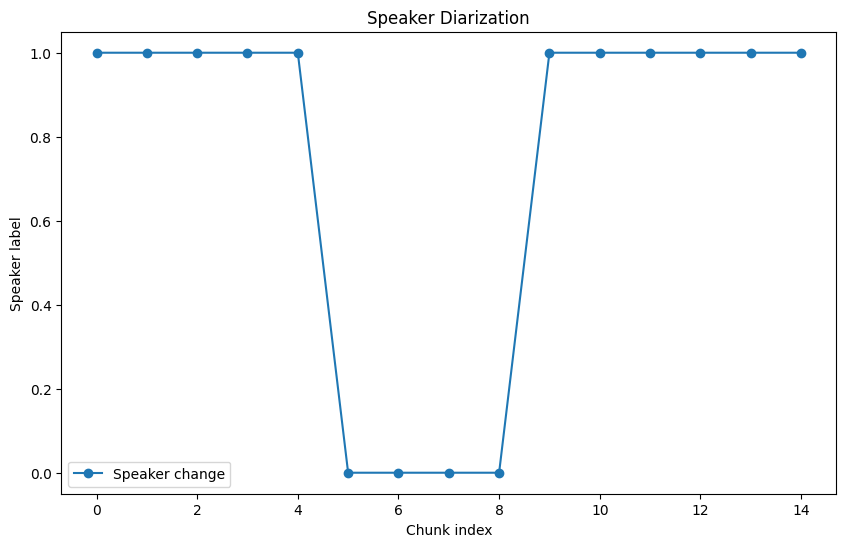

In [6]:
diarization = generate_diarization_json(chunks, labels, features_with_time)
diarization_json = json.dumps(diarization, indent=4)
print(diarization_json)

# Optional: Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(range(len(labels)), labels, 'o-', label='Speaker change')
plt.xlabel('Chunk index')
plt.ylabel('Speaker label')
plt.title('Speaker Diarization')
plt.legend()
plt.show()